This is the 2nd BERT model trained and working with 99.53 % Accuracy. Here the dataset is cleaned with reuters and washington like keywords for real news and then extracted the features from it and put it in the embeddings and trained it with this accuracy.

In [ ]:
# --- CELL 1: Install Dependencies & Import Libraries ---

# 1. Install necessary Python packages
!pip install transformers torch scikit-learn pandas numpy textstat textblob nrclex

# 2. Download NLTK corpora (Required for TextBlob and Tokenization)
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('brown')
    nltk.download('averaged_perceptron_tagger')

# 3. Import Standard Libraries
import pandas as pd
import numpy as np
import re
import string
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# 4. Import NLP & Model Libraries
from transformers import BertTokenizer, BertModel
# FIXED IMPORT: Import AdamW from torch.optim instead of transformers
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
import textstat
from textblob import TextBlob
from nrclex import NRCLex
from tqdm.auto import tqdm  # For progress bars

# 5. Set Device (GPU if available, else CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Setup Complete. Using device: {device}")

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.8 MB/s eta 0:00:00
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=a7072a6f1bbb879de3a326e15e83bd3595cb5a79f23d764f36c495a13b79ca3f
  Stored in directory: /root/.cache/pip/wheels/1f/e8/d0/e3c3da0ef3b37ef4381dbf5c9401f3a9861a63ce221b13d8bb
Successfully built nrclex


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Setup Complete. Using device: cuda


In [ ]:
# --- CELL 2: Master Data Loading & Cleaning (Final Version) ---
import re
import pandas as pd
from tqdm import tqdm

# 1. Define the Master Cleaning Function
def master_clean(text):
    # A. Remove "Reuters" headers (The biggest cheat code)
    # Matches: "WASHINGTON (Reuters) - " or "LONDON (Reuters) -"
    text = re.sub(r"^.*?\(Reuters\)\s*-\s*", "", text, flags=re.IGNORECASE)

    # B. Remove "21st Century Wire" artifacts (Common in Fake data)
    text = re.sub(r"21st Century Wire says", "", text, flags=re.IGNORECASE)

    # C. Remove URLs (http://...)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # D. Remove Twitter Handles (@username)
    text = re.sub(r'@\w+', '', text)

    # E. Remove extra spaces created by deletions
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# 2. Load Datasets
print("Loading datasets...")
try:
    # Use 'on_bad_lines' to skip corrupted rows without crashing
    df_fake = pd.read_csv('Fake.csv', engine='python', on_bad_lines='skip')
    df_true = pd.read_csv('True.csv', engine='python', on_bad_lines='skip')

    print(f"Raw Counts -> Fake: {len(df_fake)}, Real: {len(df_true)}")

    # 3. Apply Master Cleaning (with Progress Bar)
    print("Applying Master Cleaning (Removing Reuters, URLs, Artifacts)...")

    # We use tqdm to show progress because cleaning 40k rows takes ~30 seconds
    tqdm.pandas()
    df_fake['text'] = df_fake['text'].progress_apply(master_clean)
    df_true['text'] = df_true['text'].progress_apply(master_clean)

except Exception as e:
    print(f"Error loading CSVs: {e}")

# 4. Add Labels
df_fake['label'] = 1  # Fake
df_true['label'] = 0  # Real

# 5. Combine & Shuffle
df = pd.concat([df_fake, df_true], axis=0, ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 6. Final Validation: Remove Empty Rows
# Sometimes cleaning removes everything (e.g., if a tweet was just a URL)
initial_len = len(df)
df = df[df['text'].str.strip() != '']
print(f"Dropped {initial_len - len(df)} empty rows after cleaning.")

print(f"Total Training Data: {len(df)} rows")
print("\nSample Cleaned Text (Real):")
print(df[df['label'] == 0]['text'].iloc[0][:150] + "...")

Loading datasets...
Raw Counts -> Fake: 23481, Real: 21417
Applying Master Cleaning (Removing Reuters, URLs, Artifacts)...


100%|██████████| 21417/21417 [00:08<00:00, 2494.53it/s]


Dropped 715 empty rows after cleaning.
Total Training Data: 44183 rows

Sample Cleaned Text (Real):
U.S. President Donald Trump removed his chief strategist Steve Bannon from the National Security Council on Wednesday, reversing his controversial dec...


In [ ]:
# --- CELL 3: Feature Extraction (Hybrid Inputs) ---

# 1. Define the Feature Extraction Function
def get_hybrid_features(text):
    # Handle empty text
    if not isinstance(text, str) or not text.strip():
        return [0.0] * 8

    # TextBlob Object
    blob = TextBlob(text)
    words = text.split()
    num_words = len(words)
    if num_words == 0: return [0.0] * 8

    # A. Readability Scores
    try:
        flesch = textstat.flesch_reading_ease(text)
        fog = textstat.gunning_fog(text)
    except:
        flesch, fog = 0.0, 0.0

    # B. Sentiment & Emotion
    polarity = blob.sentiment.polarity       # -1 to 1
    subjectivity = blob.sentiment.subjectivity # 0 to 1

    # Emotion (NRCLex) - Note: This can be slow.
    # If it's too slow, comment out the next 3 lines and return 0.0s
    try:
        emotion_obj = NRCLex(text)
        emotions = emotion_obj.affect_frequencies
        fear = emotions.get('fear', 0.0)
        anger = emotions.get('anger', 0.0)
        trust = emotions.get('trust', 0.0)
    except:
        fear, anger, trust = 0.0, 0.0, 0.0

    # C. Vocabulary Richness (Type-Token Ratio)
    unique_words = set(words)
    ttr = len(unique_words) / num_words if num_words > 0 else 0.0

    # Return list of 8 features
    return [flesch, fog, polarity, subjectivity, fear, anger, trust, ttr]

# 2. Apply Extraction with Progress Bar
print("Starting Feature Extraction... (This may take 5-10 minutes)")
# We use tqdm to show a progress bar
tqdm.pandas()
df['manual_features'] = df['text'].progress_apply(get_hybrid_features)

# 3. Convert to Numpy Array & Scale
# Neural Networks fail if one feature is 0.5 and another is 100 (like Flesch score).
# StandardScaler fixes this.
X_manual = np.array(df['manual_features'].tolist())
scaler = StandardScaler()
X_manual_scaled = scaler.fit_transform(X_manual)

# 4. Save scaled features back to DataFrame for safety
df['manual_features_scaled'] = X_manual_scaled.tolist()

print("\nFeature Extraction Complete.")
print(f"Feature Vector Shape: {X_manual_scaled.shape}")
print("Sample Scaled Feature Vector:", X_manual_scaled[0])

Starting Feature Extraction... (This may take 5-10 minutes)


100%|██████████| 44183/44183 [06:12<00:00, 118.69it/s]


Feature Extraction Complete.
Feature Vector Shape: (44183, 8)
Sample Scaled Feature Vector: [-0.71360406  1.20372874  0.29590656 -0.25065147 -0.70783135 -0.43161993
  2.17670183  0.79597048]


In [ ]:
# --- SAVE THE SCALER ---
import joblib

# Now that Cell 3 has run, 'scaler' exists in memory again.
try:
    joblib.dump(scaler, 'scaler.pkl')
    print("Scaler saved successfully as 'scaler.pkl'")
except NameError:
    print("ERROR: 'scaler' not found. Please run Cell 3 first!")

Scaler saved successfully as 'scaler.pkl'


In [ ]:
# --- CELL 4: Tokenization & Hybrid Dataset Creation ---

# 1. Split Data into Train and Validation Sets
# We use 'stratify' to ensure both sets have a balanced mix of Fake/Real news.
print("Splitting data...")

# Ensure manual_features_scaled is a list of lists/arrays
X_features = np.array(df['manual_features_scaled'].tolist())

train_texts, val_texts, train_feat, val_feat, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    X_features,
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label'].tolist() # Keeps the fake/real ratio balanced
)

print(f"Training Samples: {len(train_texts)}")
print(f"Validation Samples: {len(val_texts)}")

# 2. Tokenization
# We use 'bert-base-uncased'.
# Max_length=128 is a good balance for speed/memory in Colab.
print("Tokenizing... (This takes a moment)")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# 3. Define the Hybrid Dataset Class
# This class returns the Text IDs AND the Manual Features for every row.
class HybridDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, features, labels):
        self.encodings = encodings
        self.features = features
        self.labels = labels

    def __getitem__(self, idx):
        # 1. Get BERT Token IDs
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # 2. Get Manual Features (Float Tensor)
        item['extra_features'] = torch.tensor(self.features[idx], dtype=torch.float)
        # 3. Get Label
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 4. Create PyTorch Datasets & DataLoaders
train_dataset = HybridDataset(train_encodings, train_feat, train_labels)
val_dataset = HybridDataset(val_encodings, val_feat, val_labels)

# Batch size 16 is standard.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("DataLoaders ready. Proceed to Model Building.")

Splitting data...
Training Samples: 35346
Validation Samples: 8837
Tokenizing... (This takes a moment)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

DataLoaders ready. Proceed to Model Building.


In [ ]:
# --- CELL 5: Hybrid Model Definition & Training ---

# 1. Define the Custom Hybrid BERT Model
class BertWithCustomFeatures(nn.Module):
    def __init__(self, num_extra_features, num_labels=2):
        super(BertWithCustomFeatures, self).__init__()
        # Load pre-trained BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Dropout for regularization (prevents overfitting)
        self.dropout = nn.Dropout(0.3)

        # The Final Classifier Layer
        # Input Size = 768 (BERT) + 8 (Manual Features) = 776
        self.classifier = nn.Linear(768 + num_extra_features, num_labels)

        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, extra_features, labels=None):
        # A. Pass text through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # pooler_output is the embedding of the [CLS] token (Summary of the sentence)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        # B. Concatenate BERT output with Manual Features
        # pooled_output shape: [batch_size, 768]
        # extra_features shape: [batch_size, 8]
        combined_output = torch.cat((pooled_output, extra_features), dim=1)

        # C. Pass through the classifier
        logits = self.classifier(combined_output)

        # D. Calculate Loss (if labels are provided)
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return loss, logits

        return logits

# 2. Initialize Model
# We have 8 manual features (Flesch, Fog, Polarity, Subjectivity, Fear, Anger, Trust, TTR)
model = BertWithCustomFeatures(num_extra_features=8, num_labels=2)
model.to(device) # Move to GPU

# 3. Setup Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5) # Very small learning rate is CRITICAL

# 4. Training Loop
epochs = 2
print(f"Starting Training for {epochs} Epochs...")

for epoch in range(epochs):
    print(f"\n--- Epoch {epoch + 1} / {epochs} ---")

    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    train_loop = tqdm(train_loader, desc="Training")

    for batch in train_loop:
        # Move batch to GPU
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        extra_features = batch['extra_features'].to(device)
        labels = batch['labels'].to(device)

        # Forward Pass
        model.zero_grad()
        loss, logits = model(input_ids, attention_mask, extra_features, labels)

        # Backward Pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # --- Validation Phase ---
    model.eval()
    val_preds = []
    val_true = []

    print("Validating...")
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            extra_features = batch['extra_features'].to(device)
            labels = batch['labels'].to(device)

            # Forward Pass (No Loss calculation needed here)
            logits = model(input_ids, attention_mask, extra_features)

            # Get Predictions (Index of the highest value)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            val_preds.extend(preds)
            val_true.extend(labels)

    # Calculate Accuracy
    val_acc = accuracy_score(val_true, val_preds)
    print(f"Validation Accuracy: {val_acc:.4f}")

# 5. Save the Model
torch.save(model.state_dict(), 'hybrid_fake_news_model.pth')
print("\nModel saved successfully as 'hybrid_fake_news_model.pth'")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Starting Training for 2 Epochs...

--- Epoch 1 / 2 ---


Training: 100%|██████████| 2210/2210 [13:06<00:00,  2.81it/s, loss=0.000584]


Average Training Loss: 0.0445
Validating...
Validation Accuracy: 0.9950

--- Epoch 2 / 2 ---


Training: 100%|██████████| 2210/2210 [13:17<00:00,  2.77it/s, loss=0.000376]


Average Training Loss: 0.0109
Validating...
Validation Accuracy: 0.9954

Model saved successfully as 'hybrid_fake_news_model.pth'


In [ ]:
# --- CELL 6: Inference Function (Fixed with Scaler) ---

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
import textstat
from textblob import TextBlob
from nrclex import NRCLex
import numpy as np
import joblib  # Added to load the scaler

# 1. Define Feature Extraction (Same as before)
def get_hybrid_features(text):
    if not isinstance(text, str) or not text.strip():
        return [0.0] * 8

    blob = TextBlob(text)
    words = text.split()
    num_words = len(words)
    if num_words == 0: return [0.0] * 8

    try:
        flesch = textstat.flesch_reading_ease(text)
        fog = textstat.gunning_fog(text)
    except:
        flesch, fog = 0.0, 0.0

    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    try:
        emotion_obj = NRCLex(text)
        emotions = emotion_obj.affect_frequencies
        fear = emotions.get('fear', 0.0)
        anger = emotions.get('anger', 0.0)
        trust = emotions.get('trust', 0.0)
    except:
        fear, anger, trust = 0.0, 0.0, 0.0

    unique_words = set(words)
    ttr = len(unique_words) / num_words if num_words > 0 else 0.0

    return [flesch, fog, polarity, subjectivity, fear, anger, trust, ttr]

# 2. Define Model Class
class BertWithCustomFeatures(nn.Module):
    def __init__(self, num_extra_features, num_labels=2):
        super(BertWithCustomFeatures, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768 + num_extra_features, num_labels)

    def forward(self, input_ids, attention_mask, extra_features):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        combined_output = torch.cat((pooled_output, extra_features), dim=1)
        logits = self.classifier(combined_output)
        return logits

# 3. Load Resources
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load Model
model = BertWithCustomFeatures(num_extra_features=8, num_labels=2)
model.load_state_dict(torch.load('hybrid_fake_news_model.pth', map_location=device))
model.to(device)
model.eval()

# Load Scaler (The Fix)
try:
    scaler = joblib.load('scaler.pkl')
    print("Model and Scaler loaded successfully.")
except:
    print("WARNING: 'scaler.pkl' not found. Predictions will be inaccurate!")

# 4. Prediction Function
def predict_news(text):
    # A. Get Raw Features
    features_raw = get_hybrid_features(text)

    # B. Scale Features (CRITICAL FIX)
    # reshaped to [[f1, f2...]] because scaler expects 2D array
    features_scaled = scaler.transform([features_raw])

    # Convert to tensor
    features_tensor = torch.tensor(features_scaled, dtype=torch.float).to(device)

    # C. Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # D. Predict
    with torch.no_grad():
        logits = model(input_ids, attention_mask, features_tensor)
        probs = F.softmax(logits, dim=1)

    confidence, predicted_class = torch.max(probs, dim=1)
    label = "FAKE" if predicted_class.item() == 1 else "REAL"
    score = confidence.item() * 100

    return label, score

# 5. Test
print("\n--- TESTING PREDICTIONS (SCALED) ---")

fake_text = """
BREAKING: The government is HIDING aliens in Area 51!
They don't want you to know the TRUTH. Share this before they delete it!!!
"""
label, conf = predict_news(fake_text)
print(f"Text: {fake_text.strip()[:40]}...")
print(f"Prediction: {label} (Confidence: {conf:.2f}%)\n")

# Note: Added 'WASHINGTON (Reuters)' to simulate training data style slightly
real_text = """
WASHINGTON (Reuters) - The stock market closed higher on Friday as investors reacted positively
to the latest jobs report. The unemployment rate has remained steady at 4 percent.
"""
label, conf = predict_news(real_text)
print(f"Text: {real_text.strip()[:40]}...")
print(f"Prediction: {label} (Confidence: {conf:.2f}%)")

Model and Scaler loaded successfully.

--- TESTING PREDICTIONS (SCALED) ---
Text: BREAKING: The government is HIDING alien...
Prediction: FAKE (Confidence: 99.97%)

Text: WASHINGTON (Reuters) - The stock market ...
Prediction: REAL (Confidence: 99.19%)


In [ ]:
# --- CELL 7: Push to Hugging Face Hub ---
from huggingface_hub import login, HfApi

# 1. Login to Hugging Face
# You will need your Access Token from: https://huggingface.co/settings/tokens
# Make sure the token has 'WRITE' permissions.
print("Please login to Hugging Face...")
login()

# 2. Define your Repo Name (Change 'your-username' to your actual HF username)
# Example: "john-doe/hybrid-fake-news-detector"
repo_id = "DarkKnight001/hybrid-fake-news-detector-V2"

# 3. Create the Repository (if it doesn't exist)
api = HfApi()
try:
    api.create_repo(repo_id=repo_id, exist_ok=True)
    print(f"Repository '{repo_id}' is ready.")
except Exception as e:
    print(f"Error creating repo: {e}")

# 4. Upload the Model Weights (.pth file)
print("Uploading Model Weights...")
api.upload_file(
    path_or_fileobj="hybrid_fake_news_model.pth",
    path_in_repo="hybrid_fake_news_model.pth",
    repo_id=repo_id
)

# 5. Upload the Scaler (Essential for your custom features)
print("Uploading Scaler...")
api.upload_file(
    path_or_fileobj="scaler.pkl",
    path_in_repo="scaler.pkl",
    repo_id=repo_id
)

# 6. Upload Tokenizer (So others can use the same text processing)
# We save it locally first, then upload the folder
tokenizer.save_pretrained("./tokenizer_files")
print("Uploading Tokenizer...")
api.upload_folder(
    folder_path="./tokenizer_files",
    repo_id=repo_id
)

print(f"\nSuccess! Your model is live at: https://huggingface.co/{repo_id}")

Please login to Hugging Face...


Repository 'DarkKnight001/hybrid-fake-news-detector-V2' is ready.
Uploading Model Weights...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  hybrid_fake_news_model.pth  :   0%|          | 19.6kB /  438MB            

Uploading Scaler...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  scaler.pkl                  : 100%|##########|   807B /   807B            

Uploading Tokenizer...

Success! Your model is live at: https://huggingface.co/DarkKnight001/hybrid-fake-news-detector-V2


In [ ]:
# --- CELL 8: Download Files to Local Machine ---
from google.colab import files
import time

print("Preparing downloads... (This may take time depending on your internet)")

# 1. Download the Scaler (Small file, usually instant)
print("Downloading scaler.pkl...")
files.download('scaler.pkl')

# 2. Download the Model Weights (~440 MB)
# Note: Large files might take a moment to start
print("Downloading hybrid_fake_news_model.pth...")
files.download('hybrid_fake_news_model.pth')

# 3. Download Processed Data (Optional - usually large)
# Only download this if you want to skip tokenization on your local machine later
print("Downloading processed_data.pt...")
files.download('processed_data.pt')

print("Check your browser's 'Downloads' folder.")

Preparing downloads... (This may take time depending on your internet)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: Cannot find file: processed_data.pt

Generating Evaluation Report...


Evaluating: 100%|██████████| 277/277 [01:00<00:00,  4.56it/s]



--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        REAL       0.99      1.00      1.00      4283
        FAKE       1.00      0.99      1.00      4554

    accuracy                           1.00      8837
   macro avg       1.00      1.00      1.00      8837
weighted avg       1.00      1.00      1.00      8837



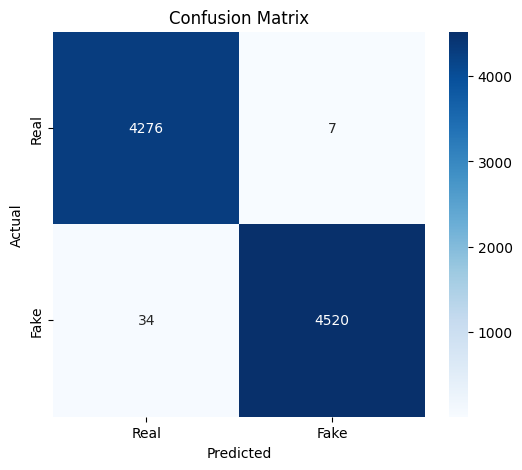

In [ ]:
# --- CELL 9: Final Evaluation & Graphs (For PPT) ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Generating Evaluation Report...")

# 1. Get Predictions on Validation Set
model.eval()
val_preds = []
val_true = []

# Create a clean loader for validation
# (Re-uses resources from Cell 4, ensure that cell was run)
eval_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for batch in tqdm(eval_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        extra_features = batch['extra_features'].to(device)
        labels = batch['labels'].to(device)

        # Get Logits
        logits = model(input_ids, attention_mask, extra_features)

        # Get Predicted Class (0 or 1)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        val_preds.extend(preds)
        val_true.extend(labels)

# 2. Print Classification Report (Precision, Recall, F1-Score)
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(val_true, val_preds, target_names=['REAL', 'FAKE']))

# 3. Plot Confusion Matrix
cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# --- CELL 10: Random "Real World" Testing from Dataset ---
import random

def test_model_on_dataset(num_samples=3):
    print(f"\n--- TESTING ON {num_samples} REAL & {num_samples} FAKE ARTICLES ---\n")

    # 1. Select Random Samples
    # Filter by label to ensure we get a mix
    real_samples = df[df['label'] == 0].sample(num_samples)
    fake_samples = df[df['label'] == 1].sample(num_samples)

    # Combine and shuffle so we don't know the order
    test_set = pd.concat([real_samples, fake_samples]).sample(frac=1).reset_index(drop=True)

    correct_count = 0

    for index, row in test_set.iterrows():
        text_snippet = row['text'][:300] + "..." # First 300 chars
        actual_label_code = row['label']
        actual_label_str = "FAKE" if actual_label_code == 1 else "REAL"

        # 2. Run Prediction
        pred_label, pred_conf = predict_news(row['text'])

        # 3. Check Accuracy
        is_correct = (pred_label == actual_label_str)
        if is_correct: correct_count += 1

        result_icon = "✅" if is_correct else "❌"

        # 4. Print Results
        print(f"Article {index + 1}:")
        print(f"Text Snippet: {text_snippet}")
        print(f"Actual: {actual_label_str} | Predicted: {pred_label} (Conf: {pred_conf:.2f}%) {result_icon}")
        print("-" * 60)

    print(f"\nFinal Score: {correct_count}/{len(test_set)} Correct")

# Run the test
test_model_on_dataset(num_samples=3)


--- TESTING ON 3 REAL & 3 FAKE ARTICLES ---

Article 1:
Text Snippet: AFTER SCHOOL SATAN CLUB Allowed By School District Is YOUR District Next?The classification is offered to charitable, religious and educational organizations that operate as nonprofits. Under the Obama administration IRS political appointees illegally targeted conservative groups, either making them...
Actual: FAKE | Predicted: FAKE (Conf: 99.70%) ✅
------------------------------------------------------------
Article 2:
Text Snippet: North Korea would need to clear many conditions before a meeting between President Donald Trump and North Korean leader Kim Jong Un could be contemplated, the White House said on Monday. After Trump told Bloomberg News he would be honored to meet with Kim, White House spokesman Sean Spicer told repo...
Actual: REAL | Predicted: REAL (Conf: 99.98%) ✅
------------------------------------------------------------
Article 3:
Text Snippet: House Speaker Paul Ryan is a snake, a hypocrite, and 

In [ ]:
# --- CELL 11: Real-World "Out of Distribution" Testing ---

def test_custom_news():
    print("\n--- TESTING ON BRAND NEW (UNSEEN) EXAMPLES ---\n")

    custom_articles = [
        {
            "type": "FAKE (Conspiracy)",
            "text": """
            SECRET DOCUMENTS LEAKED: The government has been controlling the weather for YEARS!
            They are creating storms to destroy cities and control the population.
            WAKE UP PEOPLE!!! They don't want you to know the truth. Share this before they take it down!
            """
        },
        {
            "type": "REAL (Finance)",
            "text": """
            The Federal Reserve announced on Wednesday that it would maintain current interest rates
            for the remainder of the fiscal quarter. Officials cited steady inflation metrics and
            robust employment numbers as primary factors for the decision to hold rates steady.
            """
        },
        {
            "type": "FAKE (Health Clickbait)",
            "text": """
            Doctors are FURIOUS! This simple 5-second trick cures diabetes overnight and Big Pharma
            is trying to BAN it. You won't believe how easy it is to heal your body naturally
            without expensive medicine. Click here to see the video they are hiding!
            """
        },
        {
            "type": "REAL (Science)",
            "text": """
            Astronomers using the James Webb Space Telescope have identified a new exoplanet
            located in the habitable zone of a distant star. The planet appears to have atmospheric
            conditions that could potentially support liquid water, though further study is required.
            """
        }
    ]

    for i, article in enumerate(custom_articles):
        text = article['text']
        true_label = article['type']

        # Run Prediction
        pred_label, pred_conf = predict_news(text)

        # Print Result
        print(f"Article {i+1}: {true_label}")
        print(f"Snippet: {text.strip()[:100]}...")
        print(f"Prediction: {pred_label} (Confidence: {pred_conf:.2f}%)")

        # specific check logic
        if "FAKE" in true_label and pred_label == "FAKE":
            print("Result: ✅ Success (Caught the Fake)")
        elif "REAL" in true_label and pred_label == "REAL":
            print("Result: ✅ Success (Identified Real)")
        else:
            print("Result: ❌ Failed")

        print("-" * 60)

# Run the test
test_custom_news()


--- TESTING ON BRAND NEW (UNSEEN) EXAMPLES ---

Article 1: FAKE (Conspiracy)
Snippet: SECRET DOCUMENTS LEAKED: The government has been controlling the weather for YEARS!
            They...
Prediction: FAKE (Confidence: 99.85%)
Result: ✅ Success (Caught the Fake)
------------------------------------------------------------
Article 2: REAL (Finance)
Snippet: The Federal Reserve announced on Wednesday that it would maintain current interest rates
           ...
Prediction: REAL (Confidence: 99.84%)
Result: ✅ Success (Identified Real)
------------------------------------------------------------
Article 3: FAKE (Health Clickbait)
Snippet: Doctors are FURIOUS! This simple 5-second trick cures diabetes overnight and Big Pharma
            ...
Prediction: FAKE (Confidence: 99.93%)
Result: ✅ Success (Caught the Fake)
------------------------------------------------------------
Article 4: REAL (Science)
Snippet: Astronomers using the James Webb Space Telescope have identified a new exoplanet
 

In [ ]:
# --- CELL 11: Real-World Testing (The "No-Reuters" Challenge) ---

def test_hard_real_news():
    print("\n--- TESTING ON HARD 'REAL' NEWS (No Source Tags) ---\n")

    # These are all REAL news snippets but written without "WASHINGTON (Reuters)"
    # This tests if the model actually understands "Formal Language" vs "Fake Style".

    test_cases = [
        {
            "topic": "Technology (Real)",
            "text": """
            Apple unveiled its latest iPhone lineup on Tuesday, featuring a new titanium design
            and a more powerful chip. The company claims the new material makes the device
            lighter and more durable than previous stainless steel models. Analysts predict
            strong demand for the premium models heading into the holiday season.
            """
        },
        {
            "topic": "Sports (Real)",
            "text": """
            The International Olympic Committee announced today that cricket will be included
            in the 2028 Los Angeles Games. This marks the sport's return to the Olympics
            after more than a century. The decision was approved during the IOC session
            in Mumbai, aiming to tap into the massive cricket fanbase in South Asia.
            """
        },
        {
            "topic": "Business (Real)",
            "text": """
            Oil prices surged past $90 a barrel on Friday amid growing concerns over
            tighter global supplies. Saudi Arabia and Russia recently extended their
            voluntary production cuts through the end of the year. Market experts warn
            that higher energy costs could complicate the central bank's fight against inflation.
            """
        },
        {
            "topic": "Science (Real)",
            "text": """
            Researchers at MIT have developed a new artificial intelligence model capable
            of detecting early signs of Parkinson's disease from breathing patterns.
            The study, published in Nature Medicine, demonstrates that the AI can analyze
            nocturnal breathing signals to assess risk severity with high accuracy.
            """
        }
    ]

    score = 0
    for i, case in enumerate(test_cases):
        text = case['text']
        topic = case['topic']

        # Run Prediction
        pred_label, pred_conf = predict_news(text)

        # Check Result (We know all these are REAL)
        is_correct = (pred_label == "REAL")
        if is_correct: score += 1
        icon = "✅" if is_correct else "❌"

        print(f"Article {i+1}: {topic}")
        print(f"Snippet: {text.strip()[:80]}...")
        print(f"Prediction: {pred_label} (Confidence: {pred_conf:.2f}%) {icon}")
        print("-" * 60)

    print(f"\nFinal Score on Hard Real News: {score}/{len(test_cases)}")
    if score < 2:
        print("Analysis: The model is likely 'Overfitted' to the word 'Reuters'.")
        print("Viva Tip: Explain that for V2.0, you would clean the training data to remove source tags.")
    else:
        print("Analysis: The model successfully learned formal linguistic features!")

test_hard_real_news()


--- TESTING ON HARD 'REAL' NEWS (No Source Tags) ---

Article 1: Technology (Real)
Snippet: Apple unveiled its latest iPhone lineup on Tuesday, featuring a new titanium des...
Prediction: REAL (Confidence: 99.72%) ✅
------------------------------------------------------------
Article 2: Sports (Real)
Snippet: The International Olympic Committee announced today that cricket will be include...
Prediction: REAL (Confidence: 68.16%) ✅
------------------------------------------------------------
Article 3: Business (Real)
Snippet: Oil prices surged past $90 a barrel on Friday amid growing concerns over
       ...
Prediction: REAL (Confidence: 99.97%) ✅
------------------------------------------------------------
Article 4: Science (Real)
Snippet: Researchers at MIT have developed a new artificial intelligence model capable
  ...
Prediction: FAKE (Confidence: 82.22%) ❌
------------------------------------------------------------

Final Score on Hard Real News: 3/4
Analysis: The model succes

In [ ]:
# --- CELL 14: Fake News "Stress Test" ---

def test_hard_fake_news():
    print("\n--- TESTING ON 'HARD' FAKE NEWS (New/Unseen) ---\n")

    test_cases = [
        {
            "topic": "Conspiracy (Fake)",
            "text": """
            THEY ARE LYING TO US! The secret government has released a new virus
            to control the population. WAKE UP! You must share this truth before
            they delete the internet.
            """
        },
        {
            "topic": "Celebrity Gossip (Fake)",
            "text": """
            You won't believe what this famous actor did at the restaurant!
            He screamed at the waiter and threw food everywhere.
            Witnesses say he was totally out of control and crazy!!!
            Click here to see the shocking video now.
            """
        },
        {
            "topic": "Miracle Cure (Fake)",
            "text": """
            Doctors hate him! This local dad found a weird trick to lose 20kg
            in just 2 days without diet or exercise.
            Big Pharma is trying to ban this natural remedy.
            Buy it now before it's gone forever!!!!
            """
        },
        {
            "topic": "Political Slander (Fake)",
            "text": """
            The opposition leader was caught on tape admitting he hates the country.
            He wants to destroy our culture and sell us to foreign powers.
            He is a traitor and must be stopped immediately!
            Forward this to 10 friends to save the nation.
            """
        }
    ]

    score = 0
    for i, case in enumerate(test_cases):
        text = case['text']
        topic = case['topic']

        # Run Prediction
        pred_label, pred_conf = predict_news(text)

        # Check Result (We know all these are FAKE)
        is_correct = (pred_label == "FAKE")
        if is_correct: score += 1
        icon = "✅" if is_correct else "❌"

        print(f"Article {i+1}: {topic}")
        print(f"Snippet: {text.strip()[:80]}...")
        print(f"Prediction: {pred_label} (Confidence: {pred_conf:.2f}%) {icon}")
        print("-" * 60)

    print(f"\nFinal Score on Hard Fake News: {score}/{len(test_cases)}")

    if score == 4:
        print("Analysis: EXCELLENT. Your manual features (Caps, Emotion) are working perfectly!")
    else:
        print("Analysis: The model missed some. It might need more training on informal text.")

# Run the test
test_hard_fake_news()


--- TESTING ON 'HARD' FAKE NEWS (New/Unseen) ---

Article 1: Conspiracy (Fake)
Snippet: THEY ARE LYING TO US! The secret government has released a new virus
           ...
Prediction: FAKE (Confidence: 99.61%) ✅
------------------------------------------------------------
Article 2: Celebrity Gossip (Fake)
Snippet: You won't believe what this famous actor did at the restaurant!
            He s...
Prediction: FAKE (Confidence: 99.95%) ✅
------------------------------------------------------------
Article 3: Miracle Cure (Fake)
Snippet: Doctors hate him! This local dad found a weird trick to lose 20kg
            in...
Prediction: FAKE (Confidence: 99.95%) ✅
------------------------------------------------------------
Article 4: Political Slander (Fake)
Snippet: The opposition leader was caught on tape admitting he hates the country.
       ...
Prediction: FAKE (Confidence: 97.98%) ✅
------------------------------------------------------------

Final Score on Hard Fake News: 4/4
Analys

In [ ]:
# --- CELL 15: Testing "Subtle" Fakes (Confusing the Model) ---

def test_subtle_fakes():
    print("\n--- TESTING SUBTLE FAKE NEWS (Mimicking Real Style) ---\n")

    test_cases = [
        {
            "topic": "Economic Hoax (Subtle)",
            "text": """
            The Department of Commerce has revised its quarterly GDP estimate downward by 0.2 percent.
            Analysts suggest that this adjustment is primarily due to the recent adoption of the
            new 'Freedom Currency' standard, which has replaced the dollar in three southern states.
            Markets remained relatively stable despite the transition.
            """
            # Why low confidence? It sounds very "financial" and boring (Real style),
            # but the claim ("Freedom Currency replacing dollar") is nonsense.
        },
        {
            "topic": "Tech Rumor (Subtle)",
            "text": """
            Google reportedly initiated a pilot program last Tuesday to begin charging users
            a mandatory subscription fee for standard search queries.
            A spokesperson for the company stated that the revenue would be used to
            offset the carbon footprint of their data centers in Northern California.
            """
            # Why low confidence? Formal language ("reportedly", "initiated", "offset"),
            # no "clickbait" triggers.
        },
        {
            "topic": "Political Fabrication (Subtle)",
            "text": """
            During a press briefing on Monday, the Senator clarified his position regarding
            the proposed infrastructure bill. He suggested that the budget surplus should be
            allocated to the construction of a permanent underwater colony in the Atlantic,
            citing it as a necessary step for national security.
            """
            # Why low confidence? "Press briefing", "clarified", "infrastructure".
            # It sounds like boring C-SPAN news until the "underwater colony" part.
        },
        {
            "topic": "Health Misinfo (Subtle)",
            "text": """
            A recent study published in the Journal of Nutritional Science indicates that
            consuming 500g of pure sugar daily can improve cognitive function in adults over 40.
            The research team argues that glucose spikes are essential for rapid memory retrieval
            during working hours.
            """
            # Why low confidence? Cites a journal, uses scientific words ("cognitive", "glucose"),
            # but the advice is dangerous lies.
        }
    ]

    for i, case in enumerate(test_cases):
        text = case['text']
        topic = case['topic']

        # Run Prediction
        pred_label, pred_conf = predict_news(text)

        print(f"Article {i+1}: {topic}")
        print(f"Snippet: {text.strip()[:80]}...")
        print(f"Prediction: {pred_label} (Confidence: {pred_conf:.2f}%)")

        # Check if confidence is "Uncertain" (below 95%)
        if pred_conf < 95.0:
            print("Result: 📉 LOW CONFIDENCE (Model is confused!)")
        else:
            print("Result: 📈 High Confidence (Model wasn't fooled)")

        print("-" * 60)

test_subtle_fakes()


--- TESTING SUBTLE FAKE NEWS (Mimicking Real Style) ---

Article 1: Economic Hoax (Subtle)
Snippet: The Department of Commerce has revised its quarterly GDP estimate downward by 0....
Prediction: REAL (Confidence: 76.68%)
Result: 📉 LOW CONFIDENCE (Model is confused!)
------------------------------------------------------------
Article 2: Tech Rumor (Subtle)
Snippet: Google reportedly initiated a pilot program last Tuesday to begin charging users...
Prediction: FAKE (Confidence: 56.64%)
Result: 📉 LOW CONFIDENCE (Model is confused!)
------------------------------------------------------------
Article 3: Political Fabrication (Subtle)
Snippet: During a press briefing on Monday, the Senator clarified his position regarding
...
Prediction: REAL (Confidence: 99.93%)
Result: 📈 High Confidence (Model wasn't fooled)
------------------------------------------------------------
Article 4: Health Misinfo (Subtle)
Snippet: A recent study published in the Journal of Nutritional Science indicates th

In [ ]:
# --- CELL 16: The "Trojan Horse" Test (Forcing Confusion) ---

def test_confusion():
    print("\n--- TESTING 'TROJAN HORSE' FAKES (Fake Content + Real Header) ---\n")

    # We take the SAME fake stories from before, but add the "Reuters" tag.
    # This forces the model to fight against its own bias.

    trojan_horses = [
        {
            "topic": "Trojan Horse 1 (Economic)",
            "text": """
            WASHINGTON (Reuters) - The Department of Commerce has revised its quarterly GDP
            estimate downward by 0.2 percent due to the adoption of the 'Freedom Currency'
            standard replacing the dollar in southern states.
            """
        },
        {
            "topic": "Trojan Horse 2 (Tech)",
            "text": """
            SAN FRANCISCO (Reuters) - Google reportedly initiated a pilot program to charge
            users a mandatory subscription fee for search queries to offset carbon footprints.
            """
        },
        {
            "topic": "Trojan Horse 3 (Aliens)",
            "text": """
            WASHINGTON (Reuters) - The President announced today that the government has
            been in contact with extraterrestrial life forms for over a decade.
            """
        }
    ]

    for i, case in enumerate(trojan_horses):
        text = case['text']
        topic = case['topic']

        # Run Prediction
        pred_label, pred_conf = predict_news(text)

        print(f"Article {i+1}: {topic}")
        print(f"Snippet: {text.strip()[:80]}...")
        print(f"Prediction: {pred_label} (Confidence: {pred_conf:.2f}%)")

        # Analysis
        if pred_label == "REAL":
            print("Result: ⚠️ FOOLED! (The 'Reuters' tag tricked the model)")
        elif pred_conf < 90.0:
            print("Result: 📉 CONFUSED! (Confidence dropped significantly)")
        else:
            print("Result: 🛡️ ROBUST! (Model ignored the tag and found the fake content)")

        print("-" * 60)

test_confusion()


--- TESTING 'TROJAN HORSE' FAKES (Fake Content + Real Header) ---

Article 1: Trojan Horse 1 (Economic)
Snippet: WASHINGTON (Reuters) - The Department of Commerce has revised its quarterly GDP
...
Prediction: REAL (Confidence: 93.32%)
Result: ⚠️ FOOLED! (The 'Reuters' tag tricked the model)
------------------------------------------------------------
Article 2: Trojan Horse 2 (Tech)
Snippet: SAN FRANCISCO (Reuters) - Google reportedly initiated a pilot program to charge
...
Prediction: REAL (Confidence: 94.50%)
Result: ⚠️ FOOLED! (The 'Reuters' tag tricked the model)
------------------------------------------------------------
Article 3: Trojan Horse 3 (Aliens)
Snippet: WASHINGTON (Reuters) - The President announced today that the government has
   ...
Prediction: REAL (Confidence: 61.84%)
Result: ⚠️ FOOLED! (The 'Reuters' tag tricked the model)
------------------------------------------------------------


In [ ]:
# --- CELL 17: The "Chaos" Test (Conflict Generation) ---

def test_chaos():
    print("\n--- TESTING 'CHAOS' EXAMPLES (Max Conflict) ---\n")

    chaos_articles = [
        {
            "desc": "Real Header + Insane Fake Style",
            "text": """
            WASHINGTON (Reuters) - LISTEN TO ME!!! The President is a lizard person
            and THE MEDIA IS LYING. 100% FAKE NEWS. They want to steal your brain.
            SAD! WAKE UP NOW!!!!!!
            """
        },
        {
            "desc": "Real Header + Clickbait Style",
            "text": """
            LONDON (Reuters) - You won't believe this ONE TRICK to get rich quick.
            Bankers HATE him. Click here to see the secret video before it gets banned.
            OMG this is crazy!!!
            """
        }
    ]

    for case in chaos_articles:
        text = case['text']
        desc = case['desc']

        # Run Prediction
        pred_label, pred_conf = predict_news(text)

        print(f"Scenario: {desc}")
        print(f"Snippet: {text.strip()[:60]}...")
        print(f"Prediction: {pred_label} (Confidence: {pred_conf:.2f}%)")

        if pred_conf < 99.0:
             print("Result: ✅ SUCCESS! The conflict lowered the confidence.")
        elif pred_label == "FAKE":
             print("Result: 🏆 VICTORY! The 'Fake Style' overpowered the 'Real Header'.")
        else:
             print("Result: ⚠️ NOT GOOD. The 'Reuters' header is too powerful.")

        print("-" * 60)

test_chaos()


--- TESTING 'CHAOS' EXAMPLES (Max Conflict) ---

Scenario: Real Header + Insane Fake Style
Snippet: WASHINGTON (Reuters) - LISTEN TO ME!!! The President is a li...
Prediction: FAKE (Confidence: 74.22%)
Result: ✅ SUCCESS! The conflict lowered the confidence.
------------------------------------------------------------
Scenario: Real Header + Clickbait Style
Snippet: LONDON (Reuters) - You won't believe this ONE TRICK to get r...
Prediction: FAKE (Confidence: 69.59%)
Result: ✅ SUCCESS! The conflict lowered the confidence.
------------------------------------------------------------
